In [1]:
import pickle
import numpy as np
from tqdm.notebook import trange, tqdm
import json
from sklearn.metrics import roc_curve, auc
from features import get_transformer, merge_entries
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.tag.perceptron import PerceptronTagger

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class PANDataset(torch.utils.data.Dataset):
    def __init__(self, seq_1_path, seq_2_path, y_path, vector_sz, max_seq_len, limit_seq_len):
        self.XX_1 = np.memmap(seq_1_path, dtype='int32', mode='r', shape=(vector_sz, max_seq_len))
        self.XX_2 = np.memmap(seq_2_path, dtype='int32', mode='r', shape=(vector_sz, max_seq_len))
        self.limit_seq_len = limit_seq_len
        self.Y = np.memmap(y_path, dtype='int32', mode='r', shape=(vector_sz))


    def __getitem__(self, index):
        x_1 = np.array(self.XX_1[index, :self.limit_seq_len])
        x_2 = np.array(self.XX_2[index, :self.limit_seq_len])
        return x_1, x_2, np.array(self.Y[index]).astype('float32')

    def __len__(self):
        return len(self.Y)

In [4]:
DATA_DIR = 'data/pan/'
GROUND_TRUTH_PATH = DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'
PREPROCESSED_DATA_PATH = '/scratch/jnw301/av_public/temp_data/pan/'
# TEMP_DATA_PATH = 'temp_data/pan/'
TEMP_DATA_PATH = '/scratch/jnw301/av_public/temp_data/pan/'

In [5]:
ground_truth = {}
with open(GROUND_TRUTH_PATH, 'r') as f:
    for l in f:
        d = json.loads(l)
        ground_truth[d['id']] = d['same']

In [6]:
with open(TEMP_DATA_PATH + 'experiment_data.p', 'rb') as f:
    (
        aucs,
        clf,
        roc_auc,
        transformer, 
        scaler,
        secondary_scaler,
        feature_sz,
        train_sz,
        train_idxs,
        test_sz,
        test_idxs
    ) = pickle.load(f)

/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SGDClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator FeatureUnion from version 0.22.1 when using version 0.24.1. This might lead to breaking code

In [7]:
def encode_pos_tags(x_path_1, x_path_2, preprocessed_path, ordered_idxs, tag_2_idx, vector_sz, max_seq_len):
    pos_token_ids_1 = np.memmap(x_path_1, dtype='int32', mode='w+', shape=(vector_sz, max_seq_len))
    pos_token_ids_2 = np.memmap(x_path_2, dtype='int32', mode='w+', shape=(vector_sz, max_seq_len))
    with open(preprocessed_path, 'r') as f:
        i = 0
        for l in tqdm(f, total=vector_sz):
            d = json.loads(l)
            doc_1 = merge_entries(d['pair'][0])
            for j, t in enumerate(doc_1['pos_tags'][:max_seq_len]):
                pos_token_ids_1[ordered_idxs[i], j] = tag_2_idx[t]

            doc_2 = merge_entries(d['pair'][1])
            for j, t in enumerate(doc_2['pos_tags'][:max_seq_len]):
                pos_token_ids_2[ordered_idxs[i], j] = tag_2_idx[t]
            i += 1
            if i % 1000 == 0:
                print(i)
    return pos_token_ids_1, pos_token_ids_2

In [11]:
tagger = PerceptronTagger()
tagset = list(tagger.classes)
tag_2_idx = {t:i for i, t in enumerate(tagset)}
idx_2_tag = {i:t for i, t in enumerate(tagset)}

In [8]:
max_seq_length = 5000

In [ ]:
pos_1_train, pos_2_train = encode_pos_tags(
    TEMP_DATA_PATH + 'pos_token_ids_1_train.npy',
    TEMP_DATA_PATH + 'pos_token_ids_2_train.npy',
    PREPROCESSED_DATA_PATH + 'preprocessed_train.jsonl',
    train_idxs,
    tag_2_idx,
    train_sz,
    5000
)

In [ ]:
pos_1_test, pos_2_test = encode_pos_tags(
    TEMP_DATA_PATH + 'pos_token_ids_1_test.npy',
    TEMP_DATA_PATH + 'pos_token_ids_2_test.npy',
    PREPROCESSED_DATA_PATH + 'preprocessed_test.jsonl',
    test_idxs,
    tag_2_idx,
    test_sz,
    5000
)

In [9]:
train = PANDataset(TEMP_DATA_PATH + 'pos_token_ids_1_train.npy', TEMP_DATA_PATH + 'pos_token_ids_2_train.npy', TEMP_DATA_PATH + 'Y_train.npy', train_sz, max_seq_length, 500)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False)

test = PANDataset(TEMP_DATA_PATH + 'pos_token_ids_1_test.npy', TEMP_DATA_PATH + 'pos_token_ids_2_test.npy', TEMP_DATA_PATH + 'Y_test.npy', test_sz, max_seq_length, 500)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [10]:
class AV_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(
                        embedding_dim,
                        hidden_dim,
                        num_layers=n_layers,
                        bidirectional=True,
#                         dropout = dropout,
                        batch_first = True
                    )
        self.fc_1 = nn.Linear(hidden_dim * 2, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.fc = nn.Linear(output_dim, 1)
    
    def forward_once(self, x):
        x = model.embedding(x)
        packed_output,(hidden_state,cell_state) = model.lstm(x)
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        output = self.fc_1(hidden)
        return output
    
    def forward(self, x1, x2):
        x1 = self.forward_once(x1)
        x2 = self.forward_once(x2)
        x = self.bn(torch.abs(x1 - x2))
        
        x = torch.sigmoid(self.fc(x))
        
        return x

In [ ]:
model = AV_Model(len(tag_2_idx), 256, 128, 2, 32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#initialize empty list to track batch losses
train_losses = []
validation_losses = []
aucs = []
model.to(device)

for epoch in range(40):
    model.train()
    train_loss = 0.0
    for x1, x2, y in tqdm(train_loader):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y = y.reshape(-1, 1)
        optimizer.zero_grad()
        
        out = model(x1, x2)
        loss = criterion(out, y)
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    
    preds = []
    labels = []
    for x1, x2, y in test_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y = y.reshape(-1, 1)
        out = model(x1, x2)
        loss = criterion(out, y)
        valid_loss += loss.item()
        
        out = out.reshape(-1).tolist()
        y = y.reshape(-1).tolist()
        preds.extend(out)
        labels.extend(y)
    fpr, tpr, thresh = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    train_losses.append(train_loss / len(train_loader))
    validation_losses.append(valid_loss / len(test_loader))
    print(f'Epoch {epoch+1} \t Training Loss: {train_loss / len(train_loader)} \t Validation Loss: {valid_loss / len(test_loader)} \t AUC: {roc_auc}')
    torch.save(model, TEMP_DATA_PATH + 'pytorch_model.pt')

cuda


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 1 	 Training Loss: 0.6981402509821155 	 Validation Loss: 0.6910806051840462 	 AUC: 0.5212444414675037


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 2 	 Training Loss: 0.6878536710190395 	 Validation Loss: 0.6902392723259055 	 AUC: 0.5291163356305479


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 3 	 Training Loss: 0.6852631868508757 	 Validation Loss: 0.6894856045101064 	 AUC: 0.536819482335605


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 4 	 Training Loss: 0.6812879433313375 	 Validation Loss: 0.6884743247686794 	 AUC: 0.545890511039736


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 5 	 Training Loss: 0.6728802466045611 	 Validation Loss: 0.6749087733895098 	 AUC: 0.5956327241085838


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 6 	 Training Loss: 0.656722113017052 	 Validation Loss: 0.6501221320186502 	 AUC: 0.6528589989221726


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 7 	 Training Loss: 0.6384621273194041 	 Validation Loss: 0.6401110087839564 	 AUC: 0.6732263024845839


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 8 	 Training Loss: 0.6275715434519702 	 Validation Loss: 0.6366173741226078 	 AUC: 0.6747964903761644


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 9 	 Training Loss: 0.6170649238758616 	 Validation Loss: 0.6335888532878085 	 AUC: 0.6809745000421844


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 10 	 Training Loss: 0.6101169380797911 	 Validation Loss: 0.632792374924081 	 AUC: 0.6852815324565338


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 11 	 Training Loss: 0.5999362383964201 	 Validation Loss: 0.6296385293259822 	 AUC: 0.690382263259901


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 12 	 Training Loss: 0.5889218688287117 	 Validation Loss: 0.6304714492814217 	 AUC: 0.692130949335386


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 13 	 Training Loss: 0.577026613253765 	 Validation Loss: 0.6306717934177 	 AUC: 0.6949424373359026


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 14 	 Training Loss: 0.5640179267320683 	 Validation Loss: 0.6318493320863816 	 AUC: 0.6979812243761582


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 15 	 Training Loss: 0.5501298513953332 	 Validation Loss: 0.6347608764346416 	 AUC: 0.6995602528422113


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 16 	 Training Loss: 0.5356508923507242 	 Validation Loss: 0.6401454150769714 	 AUC: 0.6995961146025205


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 17 	 Training Loss: 0.5215048656537735 	 Validation Loss: 0.6478551219852405 	 AUC: 0.6966178740046862


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 18 	 Training Loss: 0.5071933896098503 	 Validation Loss: 0.6559922538011941 	 AUC: 0.6969645681755058


  0%|          | 0/1512 [00:00<?, ?it/s]

Epoch 19 	 Training Loss: 0.4926854900858074 	 Validation Loss: 0.6665367127952635 	 AUC: 0.6958589135108112


  0%|          | 0/1512 [00:00<?, ?it/s]

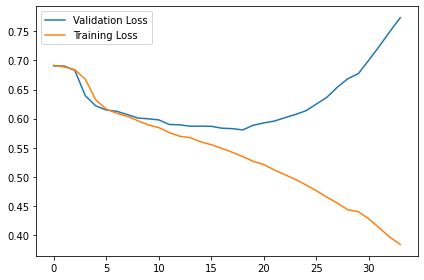

In [13]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.001, model = AV_Model(len(tag_2_idx), 32, 16, 2, 8), max_length=500

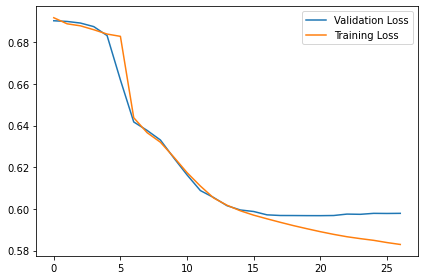

In [23]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.001, model = AV_Model(len(tag_2_idx), 32, 16, 1, 8), max_length=500

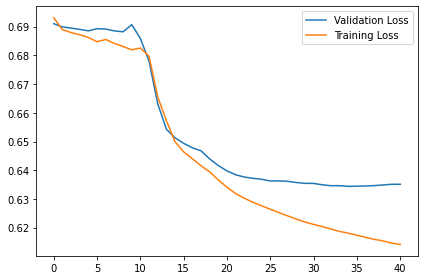

In [18]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.001, model = AV_Model(len(tag_2_idx), 32, 16, 1, 8)

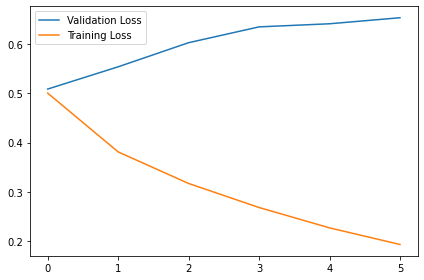

In [21]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.0001


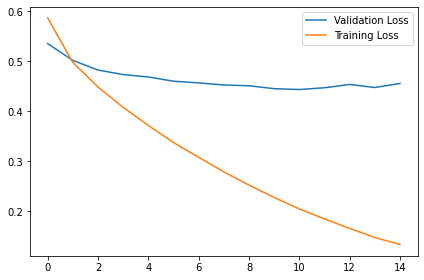

In [15]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.00001


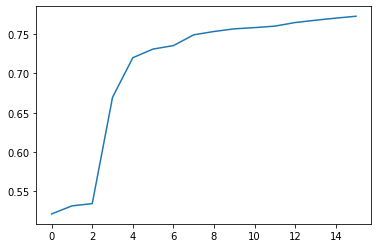

In [26]:
plt.plot(aucs)
plt.show()
# LR = 0.00001

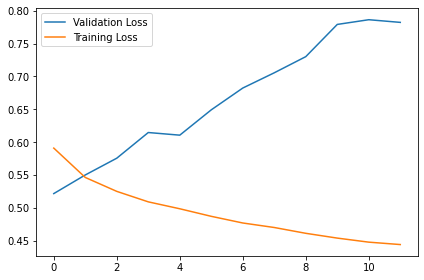

In [11]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.001


In [ ]:
model.eval()
preds = []
labels = []
for x1, x2, y in test_loader:
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    out = model(x1, x2).reshape(-1).tolist()
    y = y.reshape(-1).tolist()
    preds.extend(out)
    labels.extend(y)

In [26]:
fpr, tpr, thresh = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9980857460054038


In [33]:
torch.save(model, TEMP_DATA_PATH + 'pytorch_model.pt')